In [2]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *

E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
####################################################################################################### 
#(RUN ONLY IF NEEDED) 
#Obtain 1-normalized laplacian eigenvalues & eigenvectors from Selen's data and save them to file

f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
Adjacency = sparse.csc_matrix( (f['combined']['A']['data'], f['combined']['A']['ir'], f['combined']['A']['jc']) ).toarray()
CC = np.asarray(f['CC']['restInds'], dtype=int)
#Laplacian = sparse.csc_matrix( (f['combined']['L']['data'], f['combined']['L']['ir'], f['combined']['L']['jc']) ).toarray()
#Degree = sparse.csc_matrix( (f['combined']['DegreeM']['data'], f['combined']['DegreeM']['ir'], f['combined']['DegreeM']['jc']) ).toarray()
f.close()
indices = np.array([elem[0] for elem in CC])-1
Adjacency = Adjacency[indices,:]
Adjacency = Adjacency[:,indices]
Deg=np.sum(Adjacency, axis=0)
sqrt_Deg=np.power(Deg,-0.5)
Degree_Matrix=sp.sparse.diags(Deg)
sqrt_Degree_Matrix=sp.sparse.diags(sqrt_Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(Adjacency)
Laplacian = (sp.sparse.csc_matrix.dot(sqrt_Degree_Matrix,sp.sparse.csc_matrix.dot(regLap,sqrt_Degree_Matrix))).toarray()
Laplacian[Laplacian>1]=1

eigenvalues2, eigenvectors2 = np.linalg.eigh(Laplacian)
#eigenvectors2 matrix: each COLUMN eigenvectors2[:,i] is a normalized eigenvector

#do we want to set the first eigenvalues to the known value, which should be zero?
#eigenvalues2[0] = 0
#1-norm normalization
for col in range(eigenvectors2.shape[1]):
    eigenvectors2[:,col]/=np.sum(eigenvectors2[:,col])


#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals.npy', eigenvalues2)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy', eigenvectors2)


In [4]:
#If known, read eigenvalues and eigenvectors from file
eigenvalues2 = np.load('../data/eigvals.npy')
#eigenvectors2 = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

In [143]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 30, (0.01,500)
aIE, bnds_aIE = 20, (0.01,500)
aEI, bnds_aEI = 150, (0.01,500)
aII, bnds_aII = 15, (0.01,500)
dE, bnds_dE = 5, (0.01,20)
dI, bnds_dI = 5, (0.01,20)
P, bnds_P = 1, (0,10)
Q, bnds_Q = 0, (0,10)
sEE, bnds_sEE = 30, (0,500)
sIE, bnds_sIE = 45, (0,500)
sEI, bnds_sEI = 169, (0,500)
sII, bnds_sII = 60, (0,500)
D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0.01,10)          #unchanged
tI, bnds_tI = 1, (0.01,10)          #unchanged
snE, bnds_snE = 1, (1,10)        #unchanged
snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,D,tE,tI,snE,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_D,bnds_tE,bnds_tI,bnds_snE,bnds_snI]

Graph_Kernel='Gaussian'
first_k=2
True_Spectrum = 15*(np.arange(first_k,5000)**(-0.3))
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Args = (eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, Visual, SaveFiles)

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665


<IPython.core.display.Javascript object>


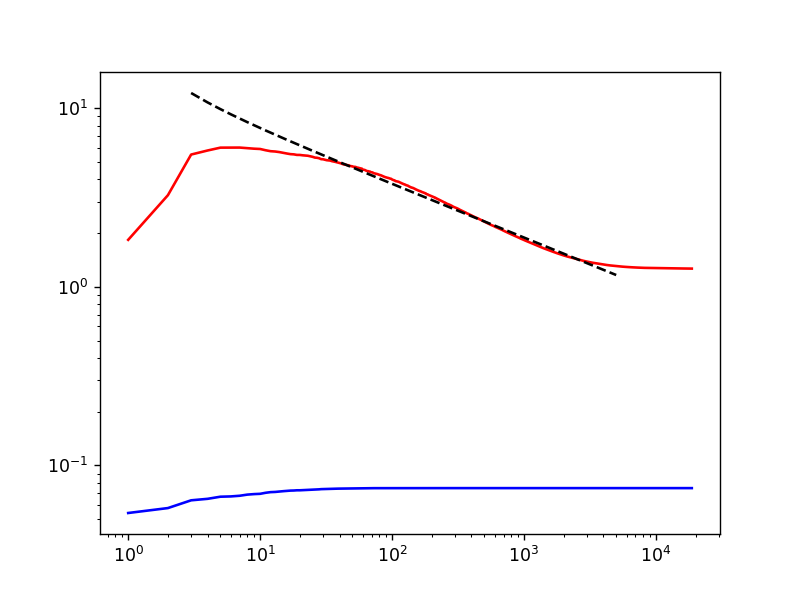

12.665411086970716

In [148]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
Full_Analysis(better_result['x'], eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, True, SaveFiles, FilePath)

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

#initial_guess=better_result['x']
result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead',#'L-BFGS-B', 
                              bounds=bnds, 
                              tol=1e-08)
                             # options={'maxiter':2000})

In [ ]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

new_initial_guess=better_result['x']
#new_initial_guess=initial_guess

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        Steady_States, Success = H_Simple_Steady_State(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
        print(t and Success)
        return t and Success
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

mybounds = MyBounds()

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
    return sp.optimize.minimize(fun,x0,args=Args, method='L-BFGS-B', bounds=Bounds,
                                tol=1e-08,
                                options={'maxiter':1000})


better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=100, stepsize=0.1,
                                  minimizer_kwargs=dict(method=custom_min),
                                  accept_test=MyBounds())

#initial_guess=better_result['x']

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.61
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189,

Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=

Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.563
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.03

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 52.447
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.665
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.659
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 48.659
Best suitable steady state: 0, with Ess=0.

Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Ess=0.203 Iss=0.206, Distance: 45.806
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.59
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 84445.505
Best suitab

Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 223.357
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.452
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.452
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.452
Best suitable steady state: 

Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.291
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.29
Best suitable steady state: 0, with Ess=0.20

Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Ess=0.204 Iss=0.205, Distance: 43.288
Best suitable steady state: 0, with Es

E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\numpy\lib\scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
E:\My Documents\Dropbox\Amsterdam Math\Rikkert Hindriks\Graph-Stochastic-Wilson-Cowan-Model\core\analysis.py:169: RuntimeWarning: invalid value encountered in greater
  if np.any(Jacobian_eigenvalues.real>0.1) or np.any(np.isnan(Jacobian_eigenvalues)):
E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.033 Iss=0.192, Distance: 110.243
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.033 Iss=0.192, Distance: 110.243
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.204 Iss=0.204, Distance: 115.707
Best suitable steady state: 0, with Ess=0.033 Iss=0.192, Distance: 110.243
Best suitable steady stat

Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.789
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 82365.872
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 51.157
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 51.157
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 51.157
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 51.157
Best suitable steady state: 0, with Ess=0.198 Iss=0.208, Distance: 51.157
Best suitable 

Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 212.359
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 48.937
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 48.937
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 48.937
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 48.937
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 48.937
Best suitable steady state: 0,

Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.029 Iss=0.186, Distance: 112.962
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady state: 0, with Ess=0.192 Iss=0.205, Distance: 116.034
Best suitable steady stat

Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.01
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.095
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 84016.094
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 45.075
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 45.075
Best s

Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 46.805
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 46.805
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 46.805
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 46.805
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.776
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83397.777
Best suitab

Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 47.86
Best suitable steady state: 0, with Ess=0.202 Iss=0

Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.682
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.682
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.682
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.682
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.682
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 40.038
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 40.038
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.919
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 33.949
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 33.949
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Ess=0.202 Iss=0.204, Distance: 42.637
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Ess=0.198 Iss=0.201, Distance: 66.566
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 53.186
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 53.186
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 53.186
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 53.186
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 53.186
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=0.2 Iss=0.204, Distance: 80868.394
Best suitable steady state: 0, with Ess=

Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.654
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 13.605
Best suitable steady state: 0, with Ess=0.198 Iss=0.206, Distance: 46.406
Best suitable steady state: 0, with Ess=0.198 Iss=0.206, Distance: 46.406
Best suitable steady state: 0, with Ess=0.198 Iss=0.206, Distance: 46.406
Best suitable steady state: 0, with Ess=0.198 Is

Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.539
False
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 52.541
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 52.541
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 52.541
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 52.541
False
Best suitable steady state: 0, with Ess=0.198 Iss=0.203, Distance: 48.471
Best suitable steady state: 0, with Ess=0.032 Iss=0.188, Distance: 13.122
Best suitable steady state: 0, with Ess=0.198 Iss=0.203, Distance: 48.471
False
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 47.491
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 47.491
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 47.491
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 47.491
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 47.491
Best suitable steady 

Best suitable steady state: 1, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 45.658
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 82739.491
Best suitable steady

Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Ess=0.203 Iss=0.207, Distance: 46.466
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 13.638
Best suitable steady state: 0, with Ess=0.033 Iss=0.188, Distance: 11.736
Best suitable steady state: 0, with Ess=0.201 Iss=0.202, Distance: 49.622
Best suitable steady state: 0, with Ess=0.201 Iss=0.202, Distance: 49.622
Best suitable steady state: 0, with Ess=0.201 Iss=0.202, Distance: 49.622
Best suitable steady state: 0, with Ess=0.201 Iss=0.202, Distance: 49.622
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.531
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.614
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 82448.613
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 46.117
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 46.117
Best 

Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 83906.949
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 83907.033
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 83907.033
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 83907.033
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.197 Iss=0.205, Distance: 44.9
Best suitable steady state: 0, with Ess=0.19

Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 55.213
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 55.213
False
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, with Ess=0.205 Iss=0.205, Distance: 50.038
Best suitable steady state: 0, w

Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.33
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state: 0, with Ess=0.2 Iss=0.209, Distance: 82410.412
Best suitable steady state

Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 66.928
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 66.928
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 66.928
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 66.928
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.466
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Ess=0.196 Iss=0.206, Distance: 40.444
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 46.771
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 85476.28
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 85476.28
Best suitable steady state: 0, with Ess=0.192 Iss=0.206, Distance: 85476.28
Best suitable steady state: 0, w

Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 1, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.909
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 82252.991
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 195.108
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 195.108
Best suitable steady state: 1, with Ess=0.199 Iss=0.205, Distance: 195.108
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 195.108
Best su

Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 34.277
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Ess=0.199 Iss=0.205, Distance: 42.196
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.202 Iss=0.203, Distance: 44.742
False
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 48.417
False
Best suitable steady state: 0, with Ess=0.202 Iss=0.206, Distance: 52.075
False
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 48.066
Best suitable steady

Best suitable steady state: 0, with Ess=0.198 Iss=0.204, Distance: 57.768
False
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.03 Iss=0.187, Distance: 18.951
Best suitable steady state: 0, with Ess=0.03 Iss=0.187, Distance: 18.951
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 47.59
Best suitable steady state: 0, with Ess=0.19

Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.153
Best suitable steady state: 0, with Ess=0.195 Iss=0.207, Distance: 40.145
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 41.29
Best suitable steady state: 0, with Ess=0.197 Iss=0

Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 40.961
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Ess=0.197 Iss=0.207, Distance: 56.509
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 1, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.591
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 82247.673

Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 50.809
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 50.809
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.032 Iss=0.188, Distance: 32.819
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Ess=0.196 Iss=0.204, Distance: 41.459
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 82530.134
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 82530.051
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 82530.134
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 82530.134
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 82530.134
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.032 Iss=0.19, Distance: 12.974
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, with Ess=0.199 Iss=0.207, Distance: 49.08
Best suitable steady state: 0, 

Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 48.246
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 48.246
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.664
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.664
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.664
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best suitable steady state: 0, with Ess=0.202 Iss=0.201, Distance: 81129.665
Best 

Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.534
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.619
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 83812.618
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 209.045
B

Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 66.746
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 66.746
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.03 Iss=0.188, Distance: 29.988
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.03 Iss=0.188, Distance: 29.853
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 1, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.03 Iss=0.188, Distance: 30.087
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.03 Iss=0.188, Distance: 30.087
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess=0.199 Iss=0.208, Distance: 41.309
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 48.339
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 48.339
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 48.339
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 1, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 1, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best suitable steady state: 0, with Ess=0.197 Iss=0.203, Distance: 82974.232
Best sui

Best suitable steady state: 1, with Ess=0.194 Iss=0.207, Distance: 83989.158
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.158
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.074
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 83989.159
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 205.089
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 205.089
Bes

Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 73.824
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 73.824
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 73.824
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 73.824
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.03 Iss=0.187, Distance: 28.844
Best suitable steady state: 0, with Ess=0.03 Iss=0.187, Distance: 28.844
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=

Best suitable steady state: 0, with Ess=0.03 Iss=0.187, Distance: 28.948
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 40.003
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 43.556
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 43.556
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 43.556
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 43.556
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 82409.323
Best suitab

Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.652
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.651
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.648
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.648
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.648
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.648
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.648
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.031 Iss=0.19, Distance: 29.735
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 Iss=0.208, Distance: 40.65
Best suitable steady state: 0, with Ess=0.195 

E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in less_equal
E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in greater_equal


False
Best suitable steady state: 0, with Ess=0.031 Iss=0.186, Distance: 14.413
Best suitable steady state: 0, with Ess=0.196 Iss=0.202, Distance: 46.799
Best suitable steady state: 0, with Ess=0.196 Iss=0.202, Distance: 46.799
Best suitable steady state: 0, with Ess=0.031 Iss=0.186, Distance: 14.413
Best suitable steady state: 0, with Ess=0.196 Iss=0.202, Distance: 46.799
False
Best suitable steady state: 0, with Ess=0.201 Iss=0.204, Distance: 47.231
False
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 50.208
Best suitable steady

Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 46.953
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 107515.53
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 107515.53
Best suitable steady state: 0, with Ess=0.203 Iss=0.205, Distance: 107515.53
Best suitable steady state: 0

Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 1, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 43.054
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 56.773
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
Best suitable steady state: 0, with Ess=0.199 Iss=0.201, Distance: 42.392
False
Best suitable steady state: 0, w

Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 48.159
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.148
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Ess=0.203 Iss=0.203, Distance: 43.145
Best suitable steady state: 0, with Es

Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
Best suitable steady state: 0, with Ess=0.201 Iss=0.208, Distance: 45.47
False
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 51.074
Best suitable steady state: 0, with Ess=0.194 Iss=0.207, Distance: 51.074
Best suitable steady state: 0, with Ess=0.1

Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 117.306
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 117.306
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.031 Iss=0.188, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with Ess=0.198 Iss=0.207, Distance: 66.256
Best suitable steady state: 0, with 

Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.03 Iss=0.186, Distance: 23.109
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess=0.193 Iss=0.207, Distance: 49.556
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.322
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 82464.404
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 48.961
Best suitable steady state: 0, with Ess=0.199 Iss=0.203, Distance: 48.961
Best 

In [147]:
better_result['x']

array([ 29.7006292 ,  20.44262474, 150.48968934,  15.1880038 ,
         4.75320173,   4.89206008,   1.19351834,   0.56093785,
         8.93308146,  44.72984834, 168.89277392,  59.76170709,
         9.66636837,   1.30688795,   1.36916604,   3.96300851,
         1.        ])

<IPython.core.display.Javascript object>


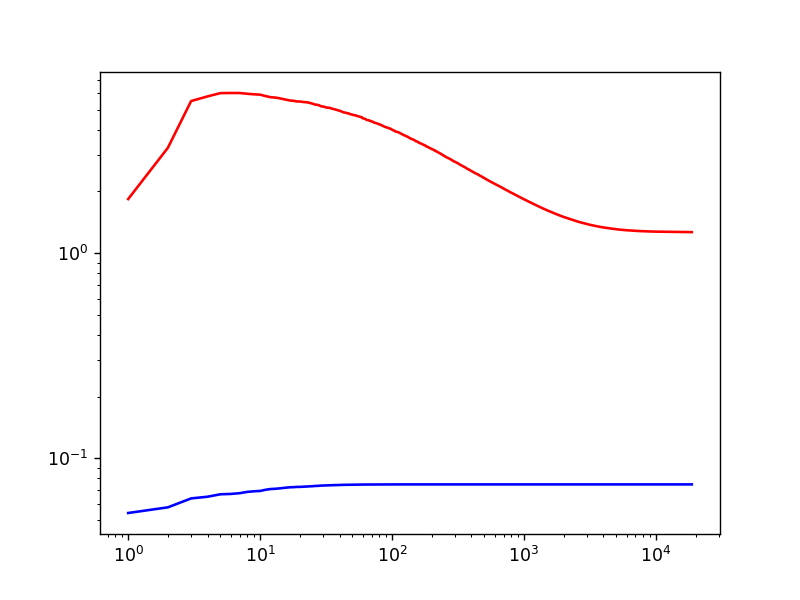

In [146]:
#re-analyze result of minimization procedure
SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
SStates       

SSnr=0

SStype, found_suitable = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14])    


Gmatrix = Graph_WC_SpatialPowerSpectrum(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                         D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14],
                                        sigma_noise_e=better_result['x'][15], sigma_noise_i=better_result['x'][16],
                                        Visual=True)

In [18]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

In [93]:
#TEST 1-2: STEADY STATES AND STABILITY VIA NUMERICAL SIMULATION
#set up 1D-specific simulation parameters and WCM propagators
one_dim=True
syn=0
gridsize=1000
h=0.01
Time=1000
Delta_t=0.001 
one_dim_eigenvalues = one_dim_Laplacian_eigenvalues(gridsize, h, syn)


#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,gridsize,2,2), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI) 


        #allG[ss,:,:,:] = Graph_WC_SpatialPowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
        #                                        alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
        #                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
        #                                         tau_e=tE, tau_i=tI
        #                                         sigma_noise_e=snE, sigma_noise_i=snI, Visual=True)

<IPython.core.display.Javascript object>


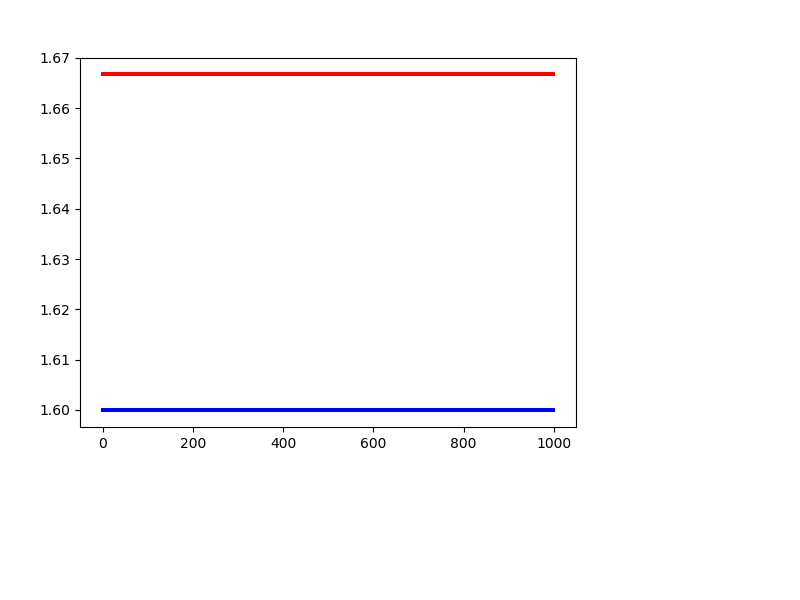

1.6666666666666667 1.6666666666666667
0
[1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667

[1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.6666

[1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679
 1.66666679 1.66666679 1.66666679 1.66666679 1.66666679 1.6666

[1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698
 1.66666698 1.66666698 1.66666698 1.66666698 1.66666698 1.6666

[1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736
 1.66666736 1.66666736 1.66666736 1.66666736 1.66666736 1.6666

[1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776
 1.66666776 1.66666776 1.66666776 1.66666776 1.66666776 1.6666

[1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787
 1.66666787 1.66666787 1.66666787 1.66666787 1.66666787 1.6666

[1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799
 1.66666799 1.66666799 1.66666799 1.66666799 1.66666799 1.6666

[1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853
 1.66666853 1.66666853 1.66666853 1.66666853 1.66666853 1.6666

[1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916
 1.66666916 1.66666916 1.66666916 1.66666916 1.66666916 1.6666

[1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933
 1.66666933 1.66666933 1.66666933 1.66666933 1.66666933 1.6666

[1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027
 1.66667027 1.66667027 1.66667027 1.66667027 1.66667027 1.6666

[1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135
 1.66667135 1.66667135 1.66667135 1.66667135 1.66667135 1.6666

[1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257
 1.66667257 1.66667257 1.66667257 1.66667257 1.66667257 1.6666

[1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393
 1.66667393 1.66667393 1.66667393 1.66667393 1.66667393 1.6666

[1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543
 1.66667543 1.66667543 1.66667543 1.66667543 1.66667543 1.6666

[1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706
 1.66667706 1.66667706 1.66667706 1.66667706 1.66667706 1.6666

[1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884
 1.66667884 1.66667884 1.66667884 1.66667884 1.66667884 1.6666

[1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035
 1.66668035 1.66668035 1.66668035 1.66668035 1.66668035 1.6666

[1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074
 1.66668074 1.66668074 1.66668074 1.66668074 1.66668074 1.6666

[1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237
 1.66668237 1.66668237 1.66668237 1.66668237 1.66668237 1.6666

[1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408
 1.66668408 1.66668408 1.66668408 1.66668408 1.66668408 1.6666

[1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497
 1.66668497 1.66668497 1.66668497 1.66668497 1.66668497 1.6666

[1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681
 1.66668681 1.66668681 1.66668681 1.66668681 1.66668681 1.6666

[1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873
 1.66668873 1.66668873 1.66668873 1.66668873 1.66668873 1.6666

[1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973
 1.66668973 1.66668973 1.66668973 1.66668973 1.66668973 1.6666

[1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231
 1.66669231 1.66669231 1.66669231 1.66669231 1.66669231 1.6666

[1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502
 1.66669502 1.66669502 1.66669502 1.66669502 1.66669502 1.6666

[1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671
 1.66669671 1.66669671 1.66669671 1.66669671 1.66669671 1.6666

[1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904
 1.66669904 1.66669904 1.66669904 1.66669904 1.66669904 1.6666

[1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085
 1.66670085 1.66670085 1.66670085 1.66670085 1.66670085 1.6667

[1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332
 1.66670332 1.66670332 1.66670332 1.66670332 1.66670332 1.6667

[1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588
 1.66670588 1.66670588 1.66670588 1.66670588 1.66670588 1.6667

[1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653
 1.66670653 1.66670653 1.66670653 1.66670653 1.66670653 1.6667

[1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719
 1.66670719 1.66670719 1.66670719 1.66670719 1.66670719 1.6667

[1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056
 1.66671056 1.66671056 1.66671056 1.66671056 1.66671056 1.6667

[1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406
 1.66671406 1.66671406 1.66671406 1.66671406 1.66671406 1.6667

[1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768
 1.66671768 1.66671768 1.66671768 1.66671768 1.66671768 1.6667

[1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144
 1.66672144 1.66672144 1.66672144 1.66672144 1.66672144 1.6667

[1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532
 1.66672532 1.66672532 1.66672532 1.66672532 1.66672532 1.6667

[1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933
 1.66672933 1.66672933 1.66672933 1.66672933 1.66672933 1.6667

[1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263
 1.66673263 1.66673263 1.66673263 1.66673263 1.66673263 1.6667

KeyboardInterrupt: 

In [24]:
#Now, run a deterministic, 1D grid simulation to verify that steady states are correct
nrSS=0          
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
E_0 = np.ones(gridsize)*Ess
I_0 = np.ones(gridsize)*Iss

propagatorEE, propagatorIE, propagatorEI, propagatorII = graph_WCM_propagators(Graph_Kernel='Gaussian',
                       alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII,
                       sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=1,
                       one_dim=one_dim, syn=syn, gridsize=gridsize, h=h)

Graph_Wilson_Cowan_Model(E_0, I_0, Time, Delta_t,
                          propagatorEE, propagatorIE, propagatorEI, propagatorII, 
                          dE, dI, P, Q, tE, tI, sigma_noise_e=0, sigma_noise_i=0, Visual=True)   

3 unique steady states were found
